In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").getOrCreate()

22/07/03 21:31:44 WARN Utils: Your hostname, DESKTOP-EJLBN3A resolves to a loopback address: 127.0.1.1; using 172.17.124.113 instead (on interface eth0)
22/07/03 21:31:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/07/03 21:31:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Set Up the Data

from pyspark.sql.types import DateType, FloatType

coffee_df = spark.read.csv("./coffee.csv", header=True)

# change the column data types
coffee_df = coffee_df.withColumn("Date", coffee_df.Date.cast(DateType()))
coffee_df = coffee_df.withColumn("Open", coffee_df.Open.cast(FloatType()))
coffee_df = coffee_df.withColumn("High", coffee_df.High.cast(FloatType()))
coffee_df = coffee_df.withColumn("Low", coffee_df.Low.cast(FloatType()))
coffee_df = coffee_df.withColumn("Close", coffee_df.Close.cast(FloatType()))
coffee_df = coffee_df.withColumn("Volume", coffee_df.Volume.cast(FloatType()))
coffee_df.show(10)
coffee_df.dtypes

+----------+------+------+------+------+-------+--------+
|      Date|  Open|  High|   Low| Close| Volume|Currency|
+----------+------+------+------+------+-------+--------+
|2000-01-03|122.25| 124.0| 116.1| 116.5| 6640.0|     USD|
|2000-01-04|116.25| 120.5|115.75|116.25| 5492.0|     USD|
|2000-01-05| 115.0| 121.0| 115.0| 118.6| 6165.0|     USD|
|2000-01-06| 119.0| 121.4| 116.5|116.85| 5094.0|     USD|
|2000-01-07|117.25|117.75| 113.8|114.15| 6855.0|     USD|
|2000-01-10| 123.5| 126.0| 116.7|117.55| 7499.0|     USD|
|2000-01-11| 115.5|118.25| 115.5| 117.8| 3976.0|     USD|
|2000-01-12| 117.8| 120.5| 116.9|118.95| 5184.0|     USD|
|2000-01-13|119.25| 120.0| 117.5|118.55| 3717.0|     USD|
|2000-01-14|117.75|120.25|112.25|112.55|10115.0|     USD|
+----------+------+------+------+------+-------+--------+
only showing top 10 rows



[('Date', 'date'),
 ('Open', 'float'),
 ('High', 'float'),
 ('Low', 'float'),
 ('Close', 'float'),
 ('Volume', 'float'),
 ('Currency', 'string')]

In [3]:
# Columns from Aggregate Functions
import pyspark.sql.functions as sf

def abs_col_values(num: int or float) -> int or float:
    "returns the absolute values of a column"
    return abs(num)

# assign the abs_col_values function to a udf
udf_abs_col_values = sf.udf(lambda x: abs_col_values(x))

coffee_df = coffee_df.withColumn("Open_Close_Diff", coffee_df.Open - coffee_df.Close)

coffee_df = coffee_df.withColumn("High_Low_Diff", coffee_df.High - coffee_df.Low)

coffee_df = coffee_df.withColumn("Vol_100plus", coffee_df.Volume >= 100)

coffee_df = coffee_df.withColumn("Open_Close_Diff", udf_abs_col_values(coffee_df.Open_Close_Diff))

# for some reason the udf turned the column datatype to a string, needs to be converted back to float
coffee_df = coffee_df.withColumn("Open_Close_Diff", coffee_df.Open_Close_Diff.cast(FloatType()))

# Compute net sales (still working on this one)
coffee_df_avgs = coffee_df.agg(
    sf.round(sf.avg("Open"), 2).alias("Open(avg)"), 
    sf.round(sf.avg("High"), 2).alias("High(avg)"), 
    sf.round(sf.avg("Low"), 2).alias("Low(avg)"), 
    sf.round(sf.avg("Close"), 2).alias("Close(avg)")
    )
coffee_df.show()
coffee_df_avgs.show()
# coffee_df.dtypes

+----------+------+------+------+------+-------+--------+---------------+-------------+-----------+
|      Date|  Open|  High|   Low| Close| Volume|Currency|Open_Close_Diff|High_Low_Diff|Vol_100plus|
+----------+------+------+------+------+-------+--------+---------------+-------------+-----------+
|2000-01-03|122.25| 124.0| 116.1| 116.5| 6640.0|     USD|           5.75|    7.9000015|       true|
|2000-01-04|116.25| 120.5|115.75|116.25| 5492.0|     USD|            0.0|         4.75|       true|
|2000-01-05| 115.0| 121.0| 115.0| 118.6| 6165.0|     USD|      3.5999985|          6.0|       true|
|2000-01-06| 119.0| 121.4| 116.5|116.85| 5094.0|     USD|      2.1500015|    4.9000015|       true|
|2000-01-07|117.25|117.75| 113.8|114.15| 6855.0|     USD|      3.0999985|     3.949997|       true|
|2000-01-10| 123.5| 126.0| 116.7|117.55| 7499.0|     USD|       5.949997|     9.300003|       true|
|2000-01-11| 115.5|118.25| 115.5| 117.8| 3976.0|     USD|       2.300003|         2.75|       true|


In [4]:
# Stats

coffee_df.show(5)

# average of the value difference between the Open and Close columns
open_close_avg = coffee_df.agg(sf.avg("Open_Close_Diff"))
open_close_avg.show()

# the number of times that Volume's values were less than 100
volume_under_100 = coffee_df.filter("Volume < 100").count()
print(volume_under_100)

# the average opening price
open_avg = coffee_df.agg(sf.avg("Open"))
open_avg.show()

# the max high value
max_high = coffee_df.agg(sf.max("High"))
max_high.show()

+----------+------+------+------+------+------+--------+---------------+-------------+-----------+
|      Date|  Open|  High|   Low| Close|Volume|Currency|Open_Close_Diff|High_Low_Diff|Vol_100plus|
+----------+------+------+------+------+------+--------+---------------+-------------+-----------+
|2000-01-03|122.25| 124.0| 116.1| 116.5|6640.0|     USD|           5.75|    7.9000015|       true|
|2000-01-04|116.25| 120.5|115.75|116.25|5492.0|     USD|            0.0|         4.75|       true|
|2000-01-05| 115.0| 121.0| 115.0| 118.6|6165.0|     USD|      3.5999985|          6.0|       true|
|2000-01-06| 119.0| 121.4| 116.5|116.85|5094.0|     USD|      2.1500015|    4.9000015|       true|
|2000-01-07|117.25|117.75| 113.8|114.15|6855.0|     USD|      3.0999985|     3.949997|       true|
+----------+------+------+------+------+------+--------+---------------+-------------+-----------+
only showing top 5 rows

+--------------------+
|avg(Open_Close_Diff)|
+--------------------+
|  1.7606027822

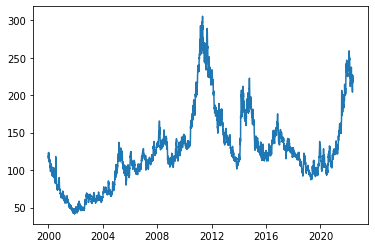

In [20]:
# Data Visualization
import matplotlib.pyplot as plt

# Here I use .select() and .collect() to gather the values of the Date and Open columns and then plot them on a chart using the matplotlib.pyplot module
date = coffee_df.select("Date").collect()
open = coffee_df.select("Open").collect()
volume = coffee_df.select("Volume").collect()
# x
# y
plt.plot(date, open)
# plt.plot(date, volume)

In [109]:
# Write File

# Writing the updated dataframe to a parquet file and reading it
coffee_df.write.parquet("./data/coffee_df.parquet", mode="overwrite")
coffee_parquet = spark.read.parquet("./data/coffee_df.parquet/")

coffee_parquet.show()
coffee_parquet.dtypes

+----------+------+------+------+------+-------+--------+---------------+-------------+-----------+
|      Date|  Open|  High|   Low| Close| Volume|Currency|Open_Close_Diff|High_Low_Diff|Vol_100plus|
+----------+------+------+------+------+-------+--------+---------------+-------------+-----------+
|2000-01-03|122.25| 124.0| 116.1| 116.5| 6640.0|     USD|           5.75|    7.9000015|       true|
|2000-01-04|116.25| 120.5|115.75|116.25| 5492.0|     USD|            0.0|         4.75|       true|
|2000-01-05| 115.0| 121.0| 115.0| 118.6| 6165.0|     USD|      3.5999985|          6.0|       true|
|2000-01-06| 119.0| 121.4| 116.5|116.85| 5094.0|     USD|      2.1500015|    4.9000015|       true|
|2000-01-07|117.25|117.75| 113.8|114.15| 6855.0|     USD|      3.0999985|     3.949997|       true|
|2000-01-10| 123.5| 126.0| 116.7|117.55| 7499.0|     USD|       5.949997|     9.300003|       true|
|2000-01-11| 115.5|118.25| 115.5| 117.8| 3976.0|     USD|       2.300003|         2.75|       true|


[('Date', 'date'),
 ('Open', 'float'),
 ('High', 'float'),
 ('Low', 'float'),
 ('Close', 'float'),
 ('Volume', 'float'),
 ('Currency', 'string'),
 ('Open_Close_Diff', 'float'),
 ('High_Low_Diff', 'float'),
 ('Vol_100plus', 'boolean')]